**Libraries**

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
import yfinance as yf
from datetime import datetime, timedelta ,timezone
from statsmodels.tsa.arima.model import ARIMA
from time import time
import itertools


**PART1**

In [2]:
## define crypto,timeframe,time range
# resource : https://finance.yahoo.com/u/yahoo-finance/watchlists/crypto-top-market-cap/
cryptos = {1:'BTC-USD', 2:'ETH-USD',3:'USDT-USD',4:'BNB-USD',5:'XRP-USD'}  ## top 5 cryptos base on market-cap
start_date = '2022-11-01'
end_date = '2023-11-01'

In [3]:
## ADF Test
## my adf test func will return true or false base on being stationary.
def modified_perform_adf_test(series):
    adf = adfuller(series)
    p_value = adf[1]
    if p_value <= 0.1 :
      return True
    return False
# btc = yf.Ticker('BTC-USD')
# btcDf = btc.history(period=timeframe, start=start_date, end=end_date)
# btcDf = btcDf[['Close']]
# res = perform_adf_test(btcDf)
# print(res)


In [4]:
### Plotting part

def plotting(tickerDf, tickerSymbol):
    plt.figure(figsize=(10, 4))
    plt.plot(tickerDf.Close)
    plt.title('Crypto (%s)' % tickerSymbol, fontsize=20)
    plt.ylabel('Price')

    # Set x-axis limits based on start_date and end_date
    min_date, max_date = tickerDf.index.min(), tickerDf.index.max()
    plt.xlim(min_date, max_date)

    # ploting crypto for specefic time
    for year in range(2022,2023):
        plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)

    plt.show()

BTC-USD: not stationary.
-------------------------------------------
ETH-USD: not stationary.
-------------------------------------------
USDT-USD: stationary.


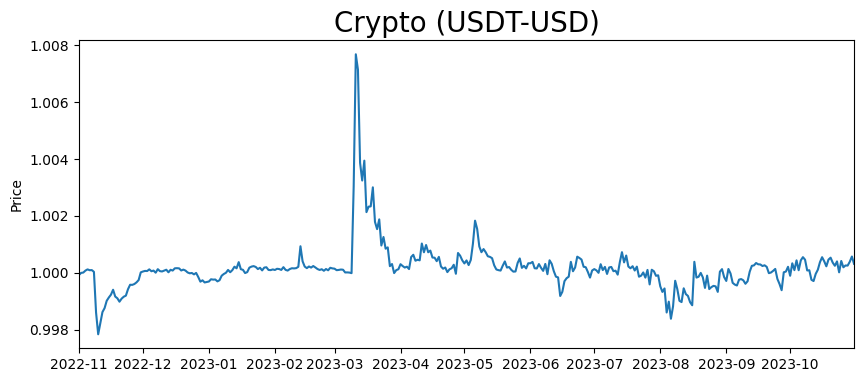

-------------------------------------------
BNB-USD: not stationary.
-------------------------------------------
XRP-USD: not stationary.
-------------------------------------------


In [5]:
## finding the best crypto and timeframe combo and plot it
# for crypto in cryptos:
#   print(cryptos[crypto])
res = {}
for i in cryptos:
        # data and its history of crypto from yahoo finance data frame
        crypto = cryptos[i]
        tickerData = yf.Ticker(crypto)
        tickerDf = tickerData.history(period='1d', start=start_date, end=end_date)
        tickerDf = tickerDf[['Close']]

        #ADF test
        is_stationary = modified_perform_adf_test(tickerDf)
        res[crypto] = is_stationary
        if is_stationary:
            print(f"{crypto}: stationary.")
            plotting(tickerDf , crypto)

        else:
            print(f"{crypto}: not stationary.")
        print('-------------------------------------------')

The only stationary crypto we find is **USDT-USD**

**PART2**

In [6]:
## accessing data from USDT-USD crypto and working with its data
# print(res)
stationary_crypto = []
print(res)
for i in res:
  if res[i] is True:
    tickerData_stationary = yf.Ticker(i)
    tickerDf_stationary = tickerData_stationary.history(period='1d', start=start_date, end=end_date)
    tickerDf_stationary = tickerDf_stationary[['Close']]
    stationary_crypto.append(tickerDf_stationary)

# print(stationary_crypto)

### we know that there is only one crypto is stationary and that is USD-USDT so we use it directly not from res

{'BTC-USD': False, 'ETH-USD': False, 'USDT-USD': True, 'BNB-USD': False, 'XRP-USD': False}


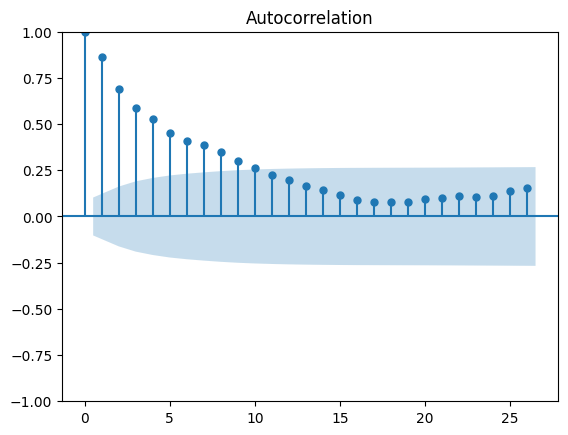

In [7]:
## ACF plot
for i in stationary_crypto:
    acf_plot = plot_acf(i)

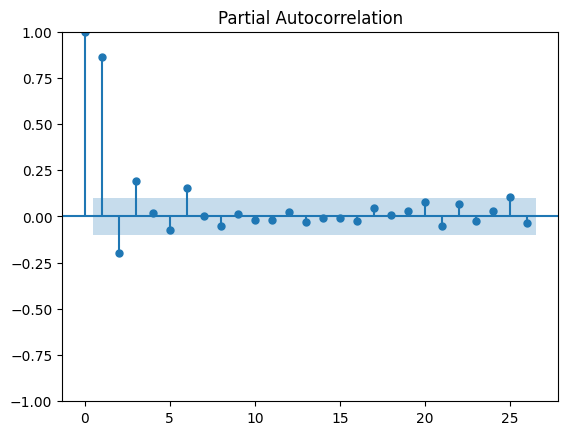

In [8]:
## PACF plot
for i in stationary_crypto:
    pacf_plot = plot_pacf(i, method='ywm')

In [9]:
## set training data and test data time range
train_final_date = datetime(2023, 10, 1)
test_final_date = datetime(2023, 11, 1)

train_data = tickerDf_stationary[:train_final_date]
test_data = tickerDf_stationary.loc[train_final_date + timedelta(days=1):test_final_date]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16344\3079603842.py:5: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  train_data = tickerDf_stationary[:train_final_date]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_16344\3079603842.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  test_data = tickerDf_stationary.loc[train_final_date + timedelta(days=1):test_final_date]


**AR Model**



In [10]:
## creating model
model = ARIMA(train_data, order=(7,0,0))

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [11]:
#fit the model
model_fit = model.fit()

#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  335
Model:                 ARIMA(7, 0, 0)   Log Likelihood                2130.036
Date:                Sun, 24 Dec 2023   AIC                          -4242.073
Time:                        18:37:58   BIC                          -4207.745
Sample:                    11-01-2022   HQIC                         -4228.387
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0002      0.000   3663.258      0.000       1.000       1.001
ar.L1          1.0979      0.023     47.131      0.000       1.052       1.144
ar.L2         -0.4271      0.036    -11.851      0.0

In [12]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
# print(test_data.Close)
test_data = test_data['Close'] ### we should use close col / if we don't use close (and adapt our code like Dr Entezari's code for AR) we get Nan value
residuals = test_data - predictions


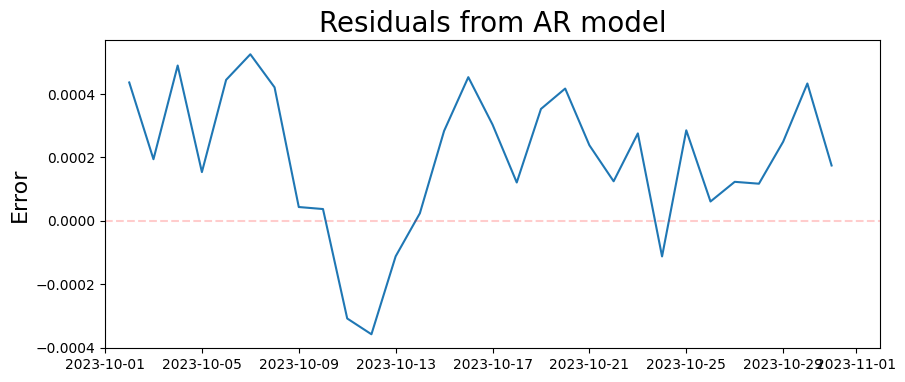

In [13]:
# print(pd.to_datetime('2023-10-01').year + 1)
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals from AR model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle ='--', alpha=0.2)

# Set x-axis limits based on start_date and end_date
plt.xlim(pd.to_datetime('2023-10-01'), pd.to_datetime('2023-11-02'))

for year in range(pd.to_datetime('2023-10-01').year, pd.to_datetime('2023-11-02').year + 1):
    plt.axvline(pd.to_datetime(str(year) + '-10-01'), color='k', linestyle='--', alpha=0.2)

plt.show()

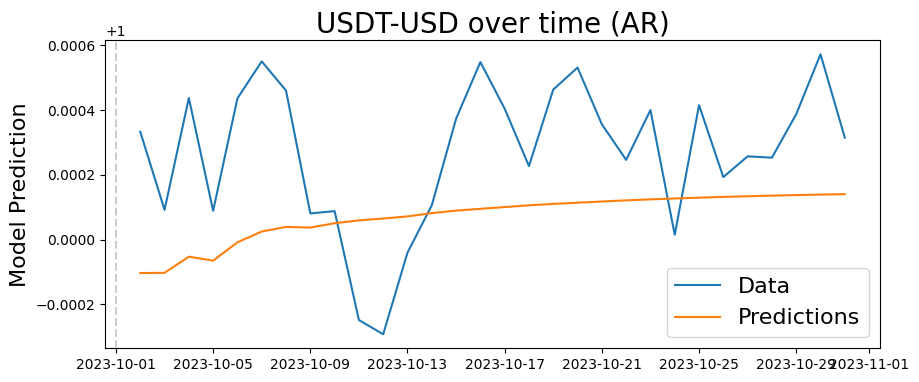

In [14]:
plt.figure(figsize=(10, 4))

# Plot only the data within the specified time period
plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('USDT-USD over time (AR)', fontsize=20)
plt.ylabel('Model Prediction', fontsize=16)

# Add vertical lines for the years
for year in range(pd.to_datetime('2023-10-01').year, pd.to_datetime('2023-11-02').year + 1):
    plt.axvline(pd.to_datetime(str(year) + '-10-01'), color='k', linestyle='--', alpha=0.2)

plt.show()


In [15]:
## MAPE ,MSE
print('Mean absolute percent error', round(np.mean(abs(residuals / test_data)),4))
print('mean squared error', np.mean(residuals**2))

## we can consider non zero test data value and mask them with this code : test_data != 0 and we get the value 9.14
## also i comment Root mean squared error since it was mentioned in question that calculate MSE not Root mean squared error # print('Root mean squared error', np.sqrt(np.mean(residuals**2)))


Mean absolute percent error 0.0003
mean squared error 8.752120654748721e-08


**MA Model**

In [16]:
## create model
model = ARIMA(train_data, order=(0,0,7))

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [17]:
#fit the model
model_fit = model.fit()

#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  335
Model:                 ARIMA(0, 0, 7)   Log Likelihood                2102.878
Date:                Sun, 24 Dec 2023   AIC                          -4187.755
Time:                        18:37:58   BIC                          -4153.428
Sample:                    11-01-2022   HQIC                         -4174.070
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0002      0.000   6160.141      0.000       1.000       1.000
ma.L1          1.0768      0.033     32.835      0.000       1.013       1.141
ma.L2          0.7611      0.048     15.902      0.0

In [18]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

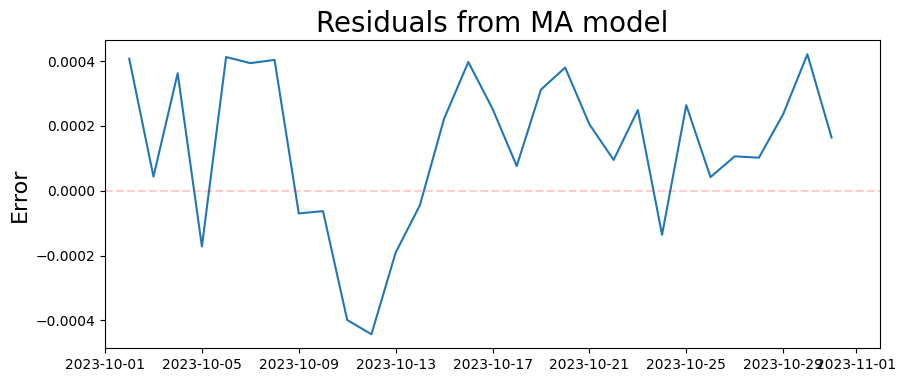

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals from MA model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle ='--', alpha=0.2)

# Set x-axis limits based on start_date and end_date
plt.xlim(pd.to_datetime('2023-10-01'), pd.to_datetime('2023-11-02'))

for year in range(pd.to_datetime('2023-10-01').year, pd.to_datetime('2023-11-02').year + 1):
    plt.axvline(pd.to_datetime(str(year) + '-10-01'), color='k', linestyle='--', alpha=0.2)

plt.show()

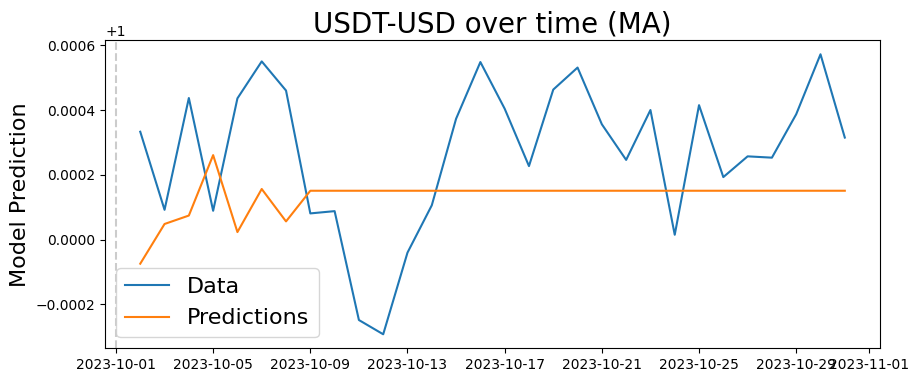

In [20]:
plt.figure(figsize=(10, 4))

# Plot only the data within the specified time period
plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('USDT-USD over time (MA)', fontsize=20)
plt.ylabel('Model Prediction', fontsize=16)

# Add vertical lines for the years
for year in range(pd.to_datetime('2023-10-01').year, pd.to_datetime('2023-11-02').year + 1):
    plt.axvline(pd.to_datetime(str(year) + '-10-01'), color='k', linestyle='--', alpha=0.2)

plt.show()

In [21]:
## MAPE ,MSE
print('Mean absolute percent error', round(np.mean(abs(residuals / test_data)),4))
print('mean squared error', np.mean(residuals**2))

## we can consider non zero test data value and mask them with this code : test_data != 0 and we get the value 8.14
## also i comment Root mean squared error since it was mentioned in question that calculate MSE not Root mean squared error  # print('Root mean squared error', np.sqrt(np.mean(residuals**2)))


Mean absolute percent error 0.0002
mean squared error 7.410540575669833e-08


**ARMA Model**

In [22]:
## create model
model = ARIMA(train_data, order=(3,0,5))

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [23]:
#fit the model
model_fit = model.fit()

#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  335
Model:                 ARIMA(3, 0, 5)   Log Likelihood                2130.206
Date:                Sun, 24 Dec 2023   AIC                          -4240.412
Time:                        18:37:59   BIC                          -4202.271
Sample:                    11-01-2022   HQIC                         -4225.206
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0002      0.000   3969.688      0.000       1.000       1.001
ar.L1          0.8851      0.011     81.662      0.000       0.864       0.906
ar.L2         -0.6900      0.009    -77.614      0.0

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

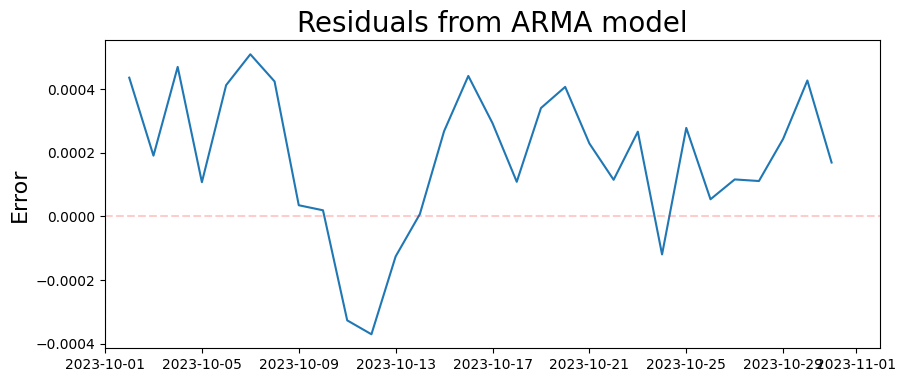

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals from ARMA model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle ='--', alpha=0.2)

# Set x-axis limits based on start_date and end_date
plt.xlim(pd.to_datetime('2023-10-01'), pd.to_datetime('2023-11-02'))

for year in range(pd.to_datetime('2023-10-01').year, pd.to_datetime('2023-11-02').year + 1):
    plt.axvline(pd.to_datetime(str(year) + '-10-01'), color='k', linestyle='--', alpha=0.2)

plt.show()

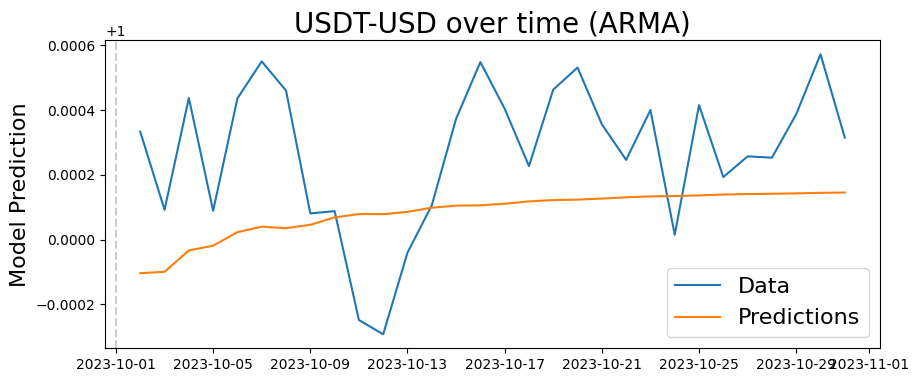

In [26]:
plt.figure(figsize=(10, 4))

# Plot only the data within the specified time period
plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('USDT-USD over time (ARMA)', fontsize=20)
plt.ylabel('Model Prediction', fontsize=16)

# Add vertical lines for the years
for year in range(pd.to_datetime('2023-10-01').year, pd.to_datetime('2023-11-02').year + 1):
    plt.axvline(pd.to_datetime(str(year) + '-10-01'), color='k', linestyle='--', alpha=0.2)

plt.show()

In [27]:
## MAPE,MSE
print('Mean absolute percent error', round(np.mean(abs(residuals / test_data)),4))
print('mean squared error', np.mean(residuals**2))

## we can consider non zero test data value and mask them with this code : test_data != 0 and we get the value 9.21
## also i comment Root mean squared error since it was mentioned in question that calculate MSE not Root mean squared error  # print('Root mean squared error', np.sqrt(np.mean(residuals**2)))


Mean absolute percent error 0.0002
mean squared error 8.362355531328917e-08


**PART 3**

In [38]:
# the range of p and q became 30 and 30 because 50 and 50 are too much and takes a lot of time

## p,q values for ARMA
p_arma = range(1, 10)
q_arma = range(1, 10)

## p,q values for AR
p_ar = range(1,31)
q_ar = (0,0)

## p,q values for MA
p_ma = (0,0)
q_ma = (1,31)

# p and q combinations
ARMA_P_Q = list(itertools.product(p_arma, q_arma))
AR_P_Q = list(itertools.product(p_ar, q_ar))
MA_P_Q = list(itertools.product(p_ma, q_ma))

# find best p,q base on least mse,mape values



In [29]:
def best_combo(combinations):
  least_mse_value = float('inf')
  least_mape_value = float('inf')
  best_model = None
  for i, j in combinations:
      order = (i, 0, j)

      # train model
      model = ARIMA(train_data, order=order)
      model_fit = model.fit()

      # model prediction
      predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)

      # MAPE and MSE we have this before
      residuals = test_data - predictions
      mse = np.mean(residuals**2)
      mape = np.mean(np.abs(residuals / test_data))

      # finding the best model best p,q combo base on least value of mape and mse
      if mse < least_mse_value and mape < least_mape_value:
          best_model = model_fit
          least_mse_value = mse
          least_mape_value = mape
          best_p_q = order

  return best_model,best_p_q,least_mse_value,least_mape_value

**PART 3 - AR**

In [30]:
## AR Model
best_model,best_p_q,least_mse_value,least_mape_value = best_combo(AR_P_Q)

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provi

Best p,q (p,q): (1, 0, 0)
Best MSE: 7.827760744902049e-08
Best MAPE: 0.00023657987938266052
-------------------------------------------


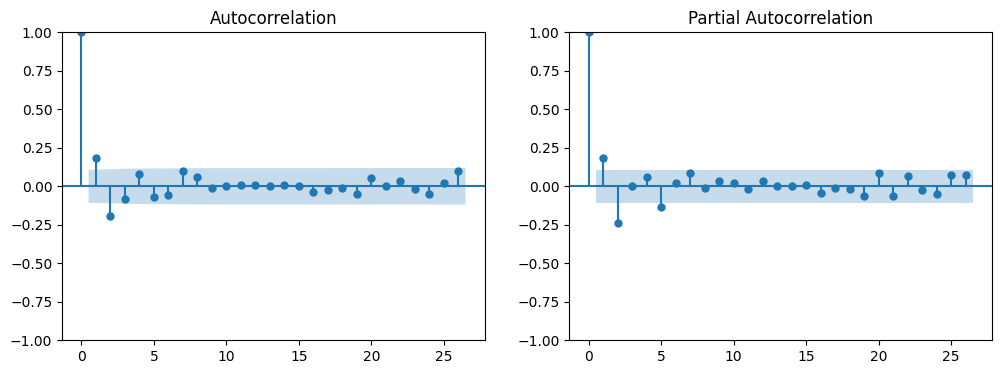

In [31]:
## Best Combo
print(f"Best p,q (p,q): {best_p_q}")

## MSE and MAPE
print(f"Best MSE: {least_mse_value}")
print(f"Best MAPE: {least_mape_value}")

print('-------------------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(best_model.resid, ax=ax[0])
plot_pacf(best_model.resid, method='ywm', ax=ax[1])
plt.show()

**PART3 - MA**

In [32]:
## MA Model
best_model,best_p_q,least_mse_value,least_mape_value = best_combo(MA_P_Q)

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information 

Best p,q (p,q): (0, 0, 1)
Best MSE: 6.250888558524325e-08
Best MAPE: 0.00021567458867278045
-------------------------------------------


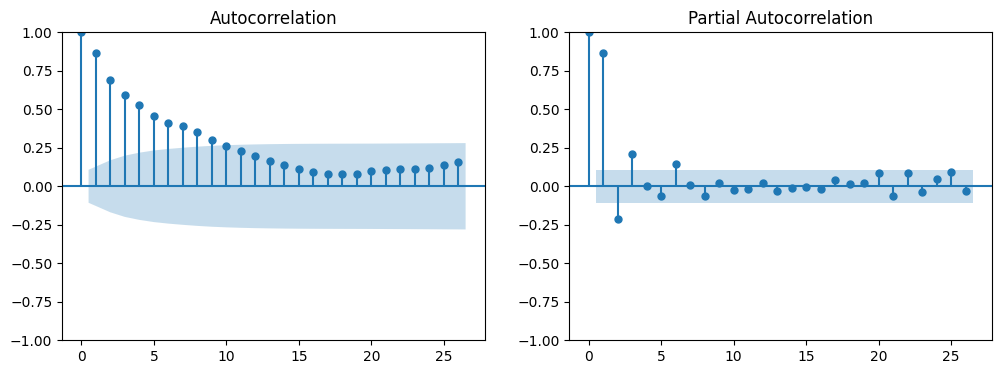

In [33]:
## Best Combo
print(f"Best p,q (p,q): {best_p_q}")

## MSE and MAPE
print(f"Best MSE: {least_mse_value}")
print(f"Best MAPE: {least_mape_value}")

print('-------------------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(best_model.resid, ax=ax[0])
plot_pacf(best_model.resid, method='ywm', ax=ax[1])
plt.show()

PART3 - ARMA

In [40]:
## ARMA model
best_model,best_p_q,least_mse_value,least_mape_value = best_combo(ARMA_P_Q)

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred fre

Best p,q (p,q): (4, 0, 9)
Best MSE: 5.972789397164323e-08
Best MAPE: 0.00019711271312061957
-------------------------------------------


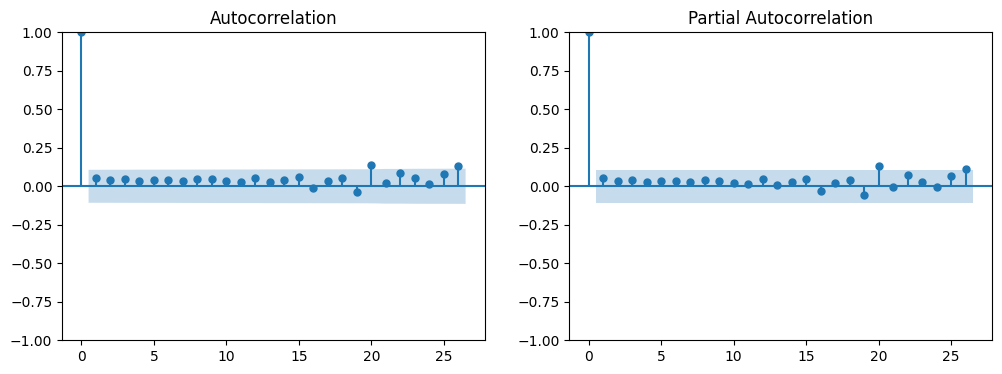

In [41]:
## Best Combo
print(f"Best p,q (p,q): {best_p_q}")

## MSE and MAPE
print(f"Best MSE: {least_mse_value}")
print(f"Best MAPE: {least_mape_value}")

print('-------------------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(best_model.resid, ax=ax[0])
plot_pacf(best_model.resid, method='ywm', ax=ax[1])
plt.show()